## Todo
- put the rest of functions/big code into py file.
- maybe reorganize
- Add colorbar to geopandas
- find better way to upload files, maybe super compressed? put into multiple parts and have code to extract them all in the py file? or a new py file?

## In this project, I will be examining trends in global temperatures from the 18th century onwards and creating visuals to convey general conclusions. 

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from TemperatureGrapher import TemperatureGrapher

In [2]:
#Opening the files
country_temps=pd.read_csv("GlobalLandTemperaturesByCountry.csv")
country_temps_average=country_temps.groupby("dt").mean()
world_temps=pd.read_csv("GlobalTemperatures.csv")
world_Landtemps_average=world_temps.groupby("dt").mean()
maj_city_temps=pd.read_csv("GlobalLandTemperaturesByMajorCity.csv")
state_temps=pd.read_csv("GlobalLandTemperaturesByState.csv")
state_temps_average=state_temps.groupby("dt").mean()
city_temps=pd.read_csv("GlobalLandTemperaturesByCity.csv")
city_temps_average=city_temps.groupby("dt").mean()

## First, I will draw several maps displaying the heat distribution across the globe in each century. Because there was little data in the 18th century, its map is less filled out than the others. 

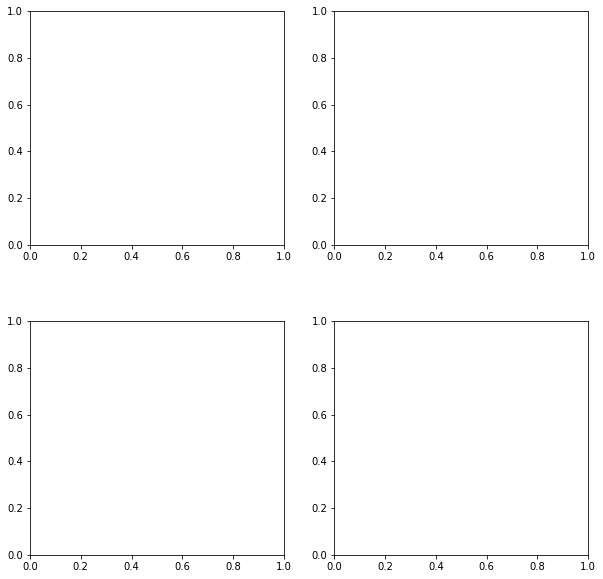

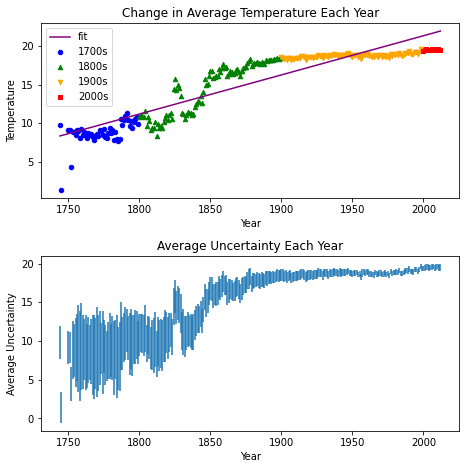

<Figure size 432x288 with 0 Axes>

The coefficient of determination is 0.8322364167832591
The data above is from the country temperatures data set.


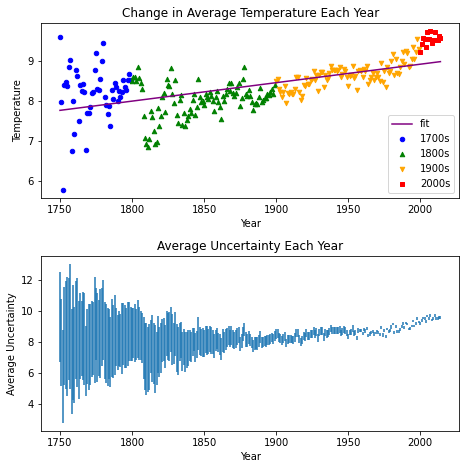

<Figure size 432x288 with 0 Axes>

The coefficient of determination is 0.36278299432134453
The data above is from the world temperatures data set.


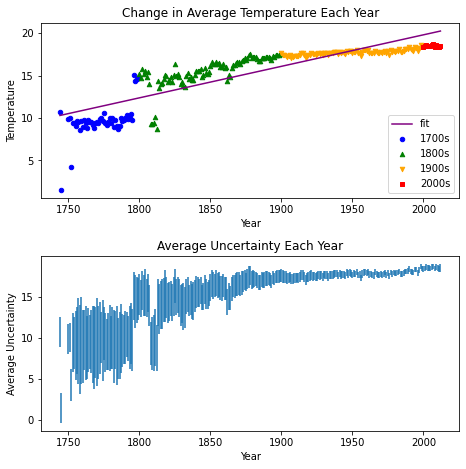

<Figure size 432x288 with 0 Axes>

The coefficient of determination is 0.7468693180564441
The data above is from the city temperatures data set.


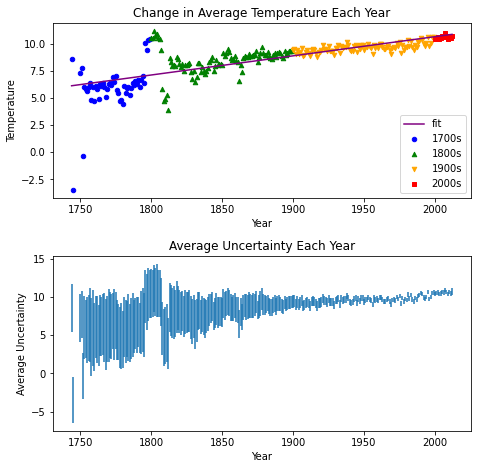

<Figure size 432x288 with 0 Axes>

The coefficient of determination is 0.5521250477380277
The data above is from the state temperatures data set.


In [3]:
fig, timeAxs=plt.subplots(2,2, figsize=(10,10)) 
plt.subplots_adjust(hspace=.33)
#Graphing the average temperature and uncertainty across different data sets.
TG = TemperatureGrapher()
TG.graph_data(country_temps_average, "AverageTemperature", "AverageTemperatureUncertainty","country temperatures",timeAxs)

In [ ]:
TG.graph_data(world_Landtemps_average, "LandAverageTemperature", "LandAverageTemperatureUncertainty","world temperatures")
TG.graph_data(city_temps_average, "AverageTemperature", "AverageTemperatureUncertainty","city temperatures")
TG.graph_data(state_temps_average, "AverageTemperature", "AverageTemperatureUncertainty","state temperatures")

In [ ]:
"""
A few countries have different names in the datasets I'm using compared to the naturalearth_lowres world dataset. As a result, I had to rename a few countries.
"""
oldNames = ["Palestina", "Dominica","French Guiana", "Netherlands (Europe)", "Bosnia And Herzegovina", "United States", "Central African Republic", "Trinidad And Tobago", "Timor Leste", "Congo (Democratic Republic Of The)", "Côte D'Ivoire"]
newNames = ["Palestine", "Dominican Rep.", "Guinea", "Netherlands", "Bosnia and Herz.", "United States of America", "Central African Rep.", "Trinidad and Tobago", "Timor-Leste", "Dem. Rep. Congo", "Côte d'Ivoire"]
for i in range(len(oldNames)):
    country_temps.loc[country_temps["Country"] == oldNames[i], "Country"] = newNames[i]

fig, heatAxs=plt.subplots(2,2, figsize=(20,10)) 
fig.patch.set_facecolor("white")
plt.suptitle("Heat Distribution in Each Century", fontsize=20,y=.93)

rows,columns = [0,0,1,1],[0,1,0,1]
for century in range(17,21):
    DF = country_temps[country_temps["dt"].str.startswith(str(century), na=False)]
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    for row in DF.groupby("Country"):
        country = row[1]["Country"].iloc[0]
        world.loc[world["name"] == country, "avgTemp"] = row[1]["AverageTemperature"].mean()
    row, column = rows.pop(0), columns.pop(0)
    world.plot(column = "avgTemp", edgecolor = "black", 
        missing_kwds = {"color": "lightgray", "edgecolor": "black"}, 
        cmap = "plasma", ax = heatAxs[row][column])
    heatAxs[row][column].tick_params(bottom = False, labelbottom = False, left = False, labelleft = False)
    heatAxs[row][column].set_title(str(century) + "00s", fontdict = {"fontsize":15})

## The following code will create four graph to display how the average temperature worldwide has changed each year. 
## As we can see below, the average temperature has been consistently increasing since the 18th century. In some graphs, there is a surge in the mid-1800s. However, it is also important to note that uncertainty about the data was much higher earlier on.


## Below, I will display which areas have had the highest increase in temperature. 
## It is important to note that different areas began recording temperatures at different times. As a result, places that began recording later will have fewer low temperatures recorded (due to the consistent increase in temperatures with time), weighing down their average. To avoid a possible misrepresentation, I grouped the areas based on when they began recording. 

In [ ]:
TG = TemperatureGrapher()

fig, timeAxs=plt.subplots(2,2, figsize=(10,10)) 
plt.subplots_adjust(hspace=.33)
plt.suptitle("Which Places Had the Highest Average Temperature, Starting at Different Times", fontsize=14,y=.93)
dataframes = [country_temps, city_temps, maj_city_temps, state_temps]
places = ["Country","City", 'City', "State"]
rows,cols = [0,0,1,1], [0,1,0,1]
for i in range(len(dataframes)):
    TG.highest_avg(dataframes[i], places[i], rows[i], cols[i],timeAxs)

